<a href="https://colab.research.google.com/github/Bhandari007/Timeseries-and-sequence-models/blob/main/C4W3_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using a multi-layer LSTM for forecasting

# Using RNNs to predict time series

In this notebook, we'll be using Tensorflow's layers for processing sequence data such as Recurrent Layers or LSTMs to see how these approaches compare.

In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass

# Generating the data

In [5]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 6 * np.pi),
                    2 / np.exp(9 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

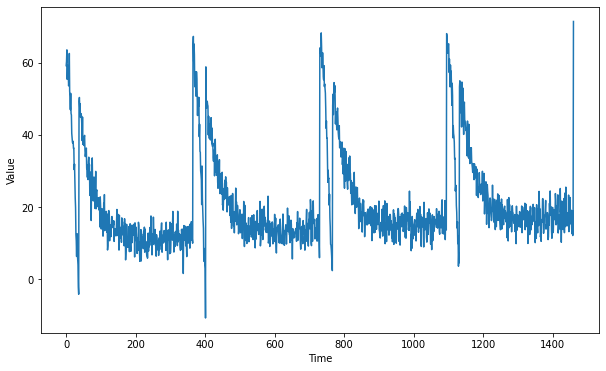

In [7]:
def generate_time_series():
  # The time dimension or the x-coordinate of the time series
  time = np.arange(4 * 365 +1 , dtype = "float32")

  # Initial series is just a straight line with a y-intercept
  y_intercept = 10
  slope = 0.005
  series = trend(time, slope) + y_intercept

  # Adding seasonality
  amplitude = 50
  series += seasonality(time, period = 365, amplitude = amplitude)

  # Adding some noise
  noise_level = 3
  series += noise(time, noise_level, seed = 51)

  return time, series

# Save all "global" variables within the G class
@dataclass
class G:
  TIME, SERIES = generate_time_series()
  SPLIT_TIME = 1100
  WINDOW_SIZE = 20
  BATCH_SIZE = 32
  SHUFFLE_BUFFER_SIZE = 1000

# Plot the generated series
plt.figure(figsize = (10,6))
plot_series(G.TIME, G.SERIES)
plt.show()

# Processing the data

In [8]:
def train_val_split(time, series, time_step = G.SPLIT_TIME):
  time_train = time[:time_step]
  series_train = series[:time_step]
  time_valid = time[time_step:]
  series_valid = series[time_step:]

  return time_train, series_train, time_valid, series_valid

time_train, series_train, time_valid, series_valid = train_val_split(G.TIME, G.SERIES)

In [12]:
def windowed_dataset(series, window_size = G.WINDOW_SIZE, batch_size = G.BATCH_SIZE,shuffle_buffer=G.SHUFFLE_BUFFER_SIZE):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size +1, shift = 1, drop_remainder = True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer)
  dataset = dataset.map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)

  return dataset

# Appply transformation to the training set
dataset = windowed_dataset(series_train)

# Defining the model architecture

In [16]:
def create_uncompiled_model():

  model = tf.keras.models.Sequential([
      tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis = -1), input_shape = [G.WINDOW_SIZE]),
      tf.keras.layers.SimpleRNN(40, return_sequences = True),
      tf.keras.layers.SimpleRNN(40),
      tf.keras.layers.Dense(1),
      tf.keras.layers.Lambda(lambda x: x*100.0)
  ])

  return model

In [17]:
# Test your uncompiled model
uncompiled_model = create_uncompiled_model()

try:
    uncompiled_model.predict(dataset)
except:
    print("Your current architecture is incompatible with the windowed dataset, try adjusting it.")
else:
    print("Your current architecture is compatible with the windowed dataset! :)")

34/34 [==============================] - 1s 6ms/step
Your current architecture is compatible with the windowed dataset! :)


# Adjusting the learning rate

In [21]:
def adjust_learning_rate():

  model = create_uncompiled_model()

  lr_schedule = tf.keras.callbacks.LearningRateScheduler(
      lambda epoch: 1e-6 * (10 ** (epoch)/20)
  )

  optimizer = tf.keras.optimizers.Adam()

  model.compile(
      loss = "mse",
      optimizer = optimizer,
      metrics = ["mae"]
  )

  history = model.fit(dataset, epochs = 100)

  return history



In [22]:
lr_history = adjust_learning_rate()

Epoch 1/100
34/34 [==============================] - 2s 11ms/step - loss: 289.8423 - mae: 12.5606
Epoch 2/100
34/34 [==============================] - 0s 11ms/step - loss: 88.3148 - mae: 5.4247
Epoch 3/100
34/34 [==============================] - 0s 11ms/step - loss: 53.5537 - mae: 4.1281
Epoch 4/100
34/34 [==============================] - 0s 11ms/step - loss: 43.2899 - mae: 3.7998
Epoch 5/100
34/34 [==============================] - 1s 26ms/step - loss: 37.0405 - mae: 3.5529
Epoch 6/100
34/34 [==============================] - 1s 10ms/step - loss: 34.0582 - mae: 3.4777
Epoch 7/100
34/34 [==============================] - 0s 10ms/step - loss: 31.2576 - mae: 3.3543
Epoch 8/100
34/34 [==============================] - 0s 11ms/step - loss: 28.7443 - mae: 3.2400
Epoch 9/100
34/34 [==============================] - 0s 10ms/step - loss: 29.3959 - mae: 3.4059
Epoch 10/100
34/34 [==============================] - 0s 10ms/step - loss: 27.7634 - mae: 3.2808
Epoch 11/100
34/34 [=================

In [23]:
# plt.semilogx(lr_history.history["lr"], lr_history.history["loss"])
# plt.axis([1e-6, 1, 0, 30])

# Compiling the model

In [24]:
def create_model():
  tf.random.set_seed(51)

  model = create_uncompiled_model()

  model.compile(loss="mae",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["mae"])
  
  return model

In [25]:
model = create_model()

history = model.fit(dataset, epochs = 50)

Epoch 1/50
34/34 [==============================] - 2s 11ms/step - loss: 6.8344 - mae: 6.8344
Epoch 2/50
34/34 [==============================] - 0s 11ms/step - loss: 4.2260 - mae: 4.2260
Epoch 3/50
34/34 [==============================] - 0s 11ms/step - loss: 3.8575 - mae: 3.8575
Epoch 4/50
34/34 [==============================] - 0s 10ms/step - loss: 3.5469 - mae: 3.5469
Epoch 5/50
34/34 [==============================] - 0s 11ms/step - loss: 3.4675 - mae: 3.4675
Epoch 6/50
34/34 [==============================] - 0s 10ms/step - loss: 3.3849 - mae: 3.3849
Epoch 7/50
34/34 [==============================] - 0s 10ms/step - loss: 3.3947 - mae: 3.3947
Epoch 8/50
34/34 [==============================] - 0s 10ms/step - loss: 3.3838 - mae: 3.3838
Epoch 9/50
34/34 [==============================] - 0s 10ms/step - loss: 3.3898 - mae: 3.3898
Epoch 10/50
34/34 [==============================] - 0s 11ms/step - loss: 3.2701 - mae: 3.2701
Epoch 11/50
34/34 [==============================] - 0s 10m

# Evaluating the forecast

In [32]:
def compute_metrics(true_series, forecast):
  mse = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()
  mae = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()

  return mse, mae

# Faster model forecasts

In [29]:
def model_forecast(model, series, window_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift = 1, drop_remainder = True)
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.batch(32).prefetch(1)
  forecast = model.predict(ds)
  return forecast

46/46 [==============================] - 1s 7ms/step


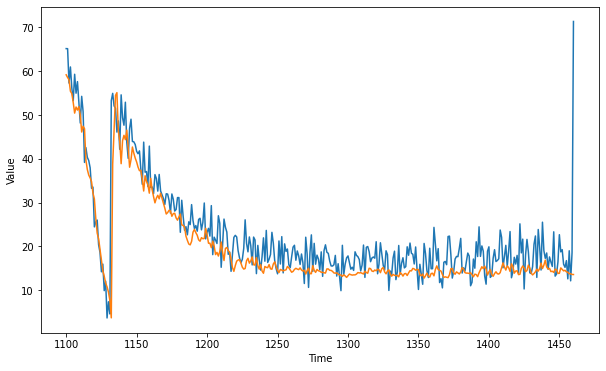

In [30]:
# Compute the forecast for all the series
rnn_forecast = model_forecast(model, G.SERIES, G.WINDOW_SIZE).squeeze()

# Slice the forecast to get only the predictions for the validation set
rnn_forecast = rnn_forecast[G.SPLIT_TIME - G.WINDOW_SIZE:-1]

# Plot it
plt.figure(figsize=(10, 6))

plot_series(time_valid, series_valid)
plot_series(time_valid, rnn_forecast) 

In [33]:
mse, mae = compute_metrics(series_valid, rnn_forecast)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

mse: 3.91, mae: 36.82 for forecast
